In [ ]:
!pip install tensorflow_similarity==0.17.1
!pip install tensorflow_addons
!pip install faiss-cpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=777)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

data = np.load('/content/drive/MyDrive/Colab Notebooks/SpaceScience/Dataset/dic_IVs&pars_uniform.npy', allow_pickle=True).item()

ri = data['ri'].reshape(-1,32)
ri = ri/np.mean(ri[:,:4],axis=-1,keepdims=True)
rv = data['rv'].reshape(-1,32)
vst = data['ground_pars']['vst']
vx = data['ground_pars']['vx']
v_cor_x = data['ground_pars']['v_cor_x']
Ti = data['ground_pars']['Ti']
O_frac = data['ground_pars']['O_frac']
H_frac = data['ground_pars']['H_frac']
AP_POT = data['ground_pars']['AP_POT']
"""
idx = np.where((O_frac>0.9)|(H_frac>0.9))
ri = np.delete(ri, idx, axis=0)
rv = np.delete(rv, idx, axis=0)
vst = np.delete(vst, idx, axis=0)
vx = np.delete(vx, idx, axis=0)
v_cor_x = np.delete(v_cor_x, idx, axis=0)
Ti = np.delete(Ti, idx, axis=0)
O_frac = np.delete(O_frac, idx, axis=0)
H_frac = np.delete(H_frac, idx, axis=0)
AP_POT = np.delete(AP_POT, idx, axis=0)
"""
LABELS = KBinsDiscretizer(
    n_bins=7,
    encode="ordinal",
    strategy='kmeans',
    random_state=777
    ).fit_transform(np.c_[0.5*(1.67262177774e-27/1.6e-19)*(16)*(vst - vx + v_cor_x)**2 + (1)*AP_POT, Ti, O_frac])

RI_ref, RI_test, RV_ref, RV_test, y_ref, y_test = train_test_split(ri, rv, LABELS, test_size=0.1, random_state=777)

In [ ]:
from scipy.special import erf
def IVcurve(x, Vx, Phi, Ti, Of):
    Vsc=7114
    pi=3.1415926
    q=1.6e-19
    k=1.38e-23
    mH=1.67262177774e-27
    mHe=(1.67262177774e-27)*4
    mO=(1.67262177774e-27)*16

    b_H= np.sqrt(mH/(2*k*Ti))
    b_He=np.sqrt(mHe/(2*k*Ti))
    b_O= np.sqrt(mO/(2*k*Ti))

    f_H= Vsc-Vx-np.sqrt( (2*q/mH)* (0.5+0.5*np.tanh(1e+19*(x+Phi))) * (x+Phi) )
    f_He=Vsc-Vx-np.sqrt( (2*q/mHe)*(0.5+0.5*np.tanh(1e+19*(x+Phi))) * (x+Phi) )
    f_O= Vsc-Vx-np.sqrt( (2*q/mO)* (0.5+0.5*np.tanh(1e+19*(x+Phi))) * (x+Phi) )

    IV= lambda b,f :0.5* (1 + erf(b*f) + np.exp(-b*b*f*f)/(np.sqrt(pi)*b*(Vsc-Vx) ))
    return (1-Of)*IV(b_H,f_H)+ Of*IV(b_O,f_O)

RV = np.array(
    [-9.93373125e-04,3.95764436e-01,6.93589837e-01,8.93694317e-01,1.09104005e+00,1.18945533e+00,1.28752994e+00,1.38576693e+00,
     1.58509721e+00,1.78320376e+00,2.17832343e+00,2.47770206e+00,2.87403719e+00,3.17350849e+00,3.57345597e+00,3.87276497e+00,
     4.17414676e+00,4.47308281e+00,4.77574920e+00,4.97875069e+00,5.18096931e+00,5.38201325e+00,5.78615054e+00,6.28558492e+00,
     6.88648143e+00,7.48722301e+00,7.98688117e+00,8.48436093e+00,9.97502566e+00,1.05e+01,1.1e+01,1.2e+01])

ground_pars = []
DATA = []
for i in range(1000000):
    Vx = np.random.uniform(-400, 400)
    Phi = np.random.uniform(-2, -0.5)
    Ti = np.random.uniform(200, 4500)
    Of = np.random.uniform(0, 1)
    ground_pars.append([Vx, Ti, Of])
    DATA.append( IVcurve(RV, Vx, Phi, Ti, Of) )
ground_pars = np.array(ground_pars)
DATA = np.array(DATA)

In [ ]:
import faiss
from scipy import stats
from tensorflow_similarity.callbacks import EvalCallback
from tensorflow_similarity.utils import unpack_results
from collections.abc import MutableMapping

class myCallback(EvalCallback):
    def __init__(self, queries, query_labels, targets, target_labels, k):
        super().__init__(queries, query_labels, targets, target_labels)
        """
        Args:
            queries: Test examples that will be tested against the built index.
            query_labels: Test examples expected ground truth labels.
            targets: Reference examples that are used to build index.
            target_labels: Reference examples labels.
            k: Number of neighbors to return for each query.
        """
        self.target_labels = target_labels # initial as numpy for fancy indexing later
        self.k = k

    def on_epoch_end(self, epoch: int, logs: MutableMapping | None = None):
        _ = epoch
        if logs is None:
            logs = {}

        # get the embeddings
        reference = self.model.predict(self.targets, verbose=0)
        test = self.model.predict(self.queries_known, verbose=0)

        # rebuild the index from reference
        index = faiss.IndexFlatL2(reference.shape[1])
        index.add(reference)

        # predict the test
        distances, indices = index.search(test, k=self.k)

        # lookup reference label via predicted indices
        votes = self.target_labels[indices] # unless self.target_labels is initial as numpy, otherwise we cannot use fancy indexing here
        #votes = tf.stack([self.target_labels.numpy()[indices[:,k]] for k in range(self.k)], axis=1) # cannot directly use fancy indexing style in the tensorflow

        # take mode as prediction output
        Vxmode, _ = stats.mode(votes[:,:,0],axis=-1,keepdims=False)
        Timode, _ = stats.mode(votes[:,:,1],axis=-1,keepdims=False)
        Ofmode, _ = stats.mode(votes[:,:,2],axis=-1,keepdims=False)

        # count how many times it correct
        VxRes = np.sum(self.query_labels_known[:, 0] == Vxmode)
        TiRes = np.sum(self.query_labels_known[:, 1] == Timode)
        OfRes = np.sum(self.query_labels_known[:, 2] == Ofmode)

        known_results = {"Vx": VxRes}, {"Ti": TiRes}, {"Of": OfRes}
        for a in known_results:
            unpack_results(
                a,
                epoch=epoch,
                logs=logs,
                tb_writer=self.tb_writer,
            )
        self.model.reset_index()

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_similarity as tfsim
import tensorflow_datasets as tfds

SEED = 777
BATCH_SIZE = 2048
INTERP_TO = 64
PROB = 0.3
XGRID = np.linspace(0, 12, INTERP_TO)

import typing
def tf_interp(x: typing.Any, xs: typing.Any, ys: typing.Any) -> tf.Tensor:
    ys = tf.convert_to_tensor(ys)
    dtype = ys.dtype

    ys = tf.cast(ys, tf.float64)
    xs = tf.cast(xs, tf.float64)
    x = tf.cast(x, tf.float64)

    xs = tf.concat([[xs.dtype.min], xs, [xs.dtype.max]], axis=0)
    ys = tf.concat([ys[:1], ys, ys[-1:]], axis=0)

    ms = (ys[1:] - ys[:-1]) / (xs[1:] - xs[:-1])
    ms = tf.pad(ms[:-1], [(1, 1)])

    bs = ys - ms*xs

    i = tf.math.argmax(xs[..., tf.newaxis, :] > x[..., tf.newaxis], axis=-1)
    m = tf.gather(ms, i, axis=-1)
    b = tf.gather(bs, i, axis=-1)

    y = m*x + b
    return tf.cast(tf.reshape(y, tf.shape(x)), dtype)

# https://stackoverflow.com/questions/58546373/how-to-add-randomness-in-each-iteration-of-tensorflow-dataset
# https://stackoverflow.com/questions/69108284/tf-data-dataset-map-functionality-and-random
# https://github.com/tensorflow/tensorflow/issues/35090#issuecomment-1345470684
#def custom_augment(ri):
#    return tf.nn.dropout(tf_interp(XGRID, RV, ri + tf.random.normal((ri.shape[-1],), 0, 0.015, dtype=ri.dtype)), rate=PROB)*(1-PROB)
RNG = tf.random.Generator.from_seed(33)
def custom_augment(ri):
    noise1 = tf.nn.experimental.general_dropout(RNG.normal(ri.shape, 0, 0.02, dtype=ri.dtype), 0.9, RNG.uniform)*(1-0.9)
    noise2 = tf.nn.experimental.general_dropout(RNG.normal(ri.shape, 0, 0.03, dtype=ri.dtype), 0.7, RNG.uniform)*(1-0.7)
    return tf_interp(XGRID, RV, ri+noise1+noise2) + RNG.normal(XGRID.shape, 0, 0.01, dtype=ri.dtype)
    #return tf_interp(XGRID, RV, ri)+RNG.normal(XGRID.shape, 0, 0.01, dtype=ri.dtype)+tf.nn.experimental.general_dropout(RNG.normal(XGRID.shape, 0, 0.04, dtype=ri.dtype), PROB, RNG.uniform)*(1-PROB)
    #return tf.nn.experimental.general_dropout(tf_interp(XGRID, RV, ri + RNG.normal((ri.shape[-1],), 0, 0.025, dtype=ri.dtype)), PROB, RNG.uniform)*(1-PROB)

train_one = (
    tf.data.Dataset.from_tensor_slices( DATA ).shuffle(buffer_size=4096, seed=SEED)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
train_two = (
    tf.data.Dataset.from_tensor_slices( DATA ).shuffle(buffer_size=4096, seed=SEED)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
train_ds = tf.data.Dataset.zip((train_one, train_two))

ref_ds = tf.data.Dataset.from_tensor_slices( (RV_ref, RI_ref) ).map(lambda rv, ri: tf_interp(XGRID, rv, ri), num_parallel_calls=tf.data.AUTOTUNE).batch(9)
test_ds = tf.data.Dataset.from_tensor_slices( (RV_test, RI_test) ).map(lambda rv, ri: tf_interp(XGRID, rv, ri), num_parallel_calls=tf.data.AUTOTUNE).batch(9)

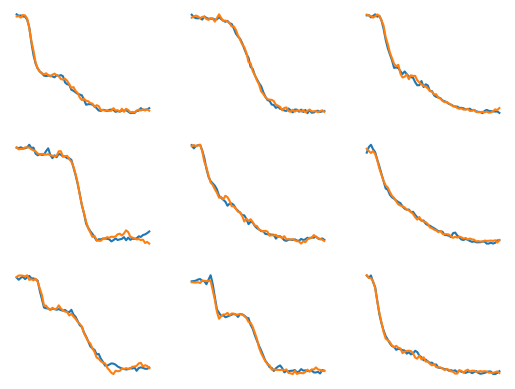

In [ ]:
import matplotlib.pyplot as plt

sample_one, sample_two = next(iter(train_ds))

plt.figure()
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    plt.plot(XGRID, sample_one[n],'-', label="one")
    plt.plot(XGRID, sample_two[n],'-',label="two")
    plt.axis("off")
plt.show()

In [ ]:
import faiss

reference = np.concatenate([x for x in tfds.as_numpy(ref_ds)])
test = np.concatenate([x for x in tfds.as_numpy(test_ds)])

# rebuild the index from reference
index = faiss.IndexFlatL2(reference.shape[1])
index.add(reference)

# predict the test
distances, indices = index.search(test, k=4)

# lookup reference label via predicted indices
votes = y_ref[indices] # unless self.target_labels is initial as numpy, otherwise we cannot use fancy indexing here
#votes = tf.stack([self.target_labels.numpy()[indices[:,k]] for k in range(self.k)], axis=1) # cannot directly use fancy indexing style in the tensorflow

# take mode as prediction output
Vxmode, _ = stats.mode(votes[:,:,0],axis=-1,keepdims=False)
Timode, _ = stats.mode(votes[:,:,1],axis=-1,keepdims=False)
Ofmode, _ = stats.mode(votes[:,:,2],axis=-1,keepdims=False)

# count how many times it correct
VxRes = np.sum(y_test[:, 0] == Vxmode)
TiRes = np.sum(y_test[:, 1] == Timode)
OfRes = np.sum(y_test[:, 2] == Ofmode)

print(VxRes, TiRes, OfRes)

283 318 398


In [ ]:
checkpoint_path = "./training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

TEMPERATURE = 0.25
INIT_LR = 1e-3
EPOCHS = 10
HID_SIZE = 16

def get_backbone(input_dim, channel=16):
    inputs = tf.keras.layers.Input((input_dim,), name="backbone_input")
    x = tf.expand_dims(inputs, axis=-1)
    x = tf.keras.layers.Conv1D(channel/8, kernel_size=5, strides=2, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(channel/4, kernel_size=5, strides=2, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(channel/2, kernel_size=5, strides=2, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(channel, kernel_size=5, strides=2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(channel, activation="relu", name="backbone_output")(x)
    return tf.keras.Model(inputs, outputs, name="backbone")

backbone = get_backbone( INTERP_TO, channel=128)
projector = tfsim.models.contrastive_model.get_projector( input_dim = backbone.output.shape[-1], dim=HID_SIZE, num_layers=2)

model = tfsim.models.ContrastiveModel(
    backbone = backbone,
    projector = projector,
    algorithm="simclr"
)

model.compile(
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR),
    loss = tfsim.losses.SimCLRLoss(name="simclr", temperature=TEMPERATURE)
)

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    callbacks=[
        myCallback(test_ds, y_test, ref_ds, y_ref, k=4),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')
    ],
    verbose = 1,
)

Epoch 1/10
489/489 [==============================] - 794s 2s/step - loss: 12.4032 - proj_std: 0.2482 - Vx: 272.0000 - Ti: 327.0000 - Of: 395.0000
Epoch 2/10
489/489 [==============================] - 774s 2s/step - loss: 10.8687 - proj_std: 0.2494 - Vx: 283.0000 - Ti: 330.0000 - Of: 393.0000
Epoch 3/10
489/489 [==============================] - 794s 2s/step - loss: 10.5374 - proj_std: 0.2496 - Vx: 285.0000 - Ti: 333.0000 - Of: 395.0000
Epoch 4/10
489/489 [==============================] - 763s 2s/step - loss: 10.4109 - proj_std: 0.2498 - Vx: 288.0000 - Ti: 325.0000 - Of: 395.0000
Epoch 5/10
489/489 [==============================] - 786s 2s/step - loss: 10.3363 - proj_std: 0.2499 - Vx: 297.0000 - Ti: 322.0000 - Of: 394.0000
Epoch 6/10
489/489 [==============================] - 774s 2s/step - loss: 10.2863 - proj_std: 0.2499 - Vx: 291.0000 - Ti: 321.0000 - Of: 398.0000
Epoch 7/10
489/489 [==============================] - 778s 2s/step - loss: 10.2492 - proj_std: 0.2499 - Vx: 298.0000 -

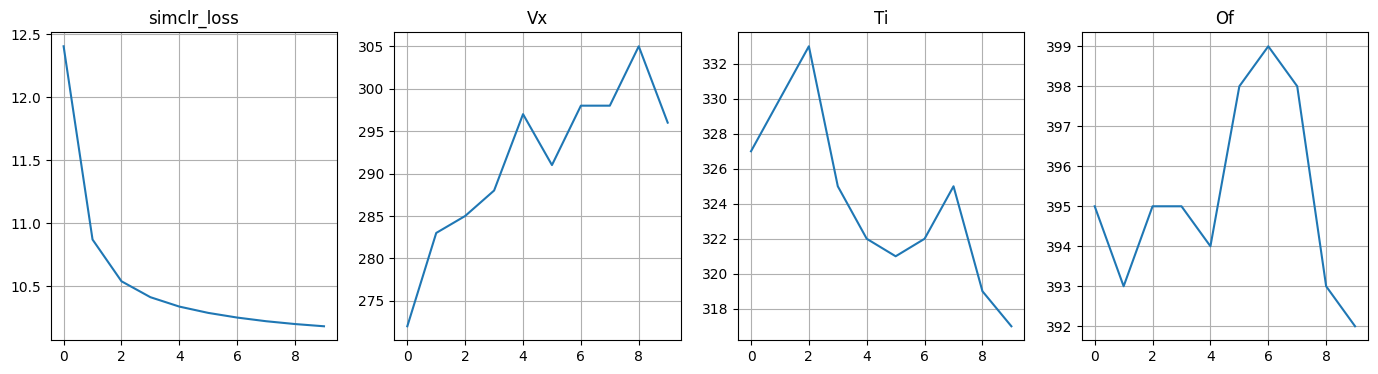

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,4))

ax1 = plt.subplot(141)
plt.plot(history.history["loss"])
plt.grid()
plt.title("simclr_loss")

ax2 = plt.subplot(142)
plt.plot(history.history["Vx"], label="error")
plt.grid()
plt.title("Vx")

ax3 = plt.subplot(143)
plt.plot(history.history["Ti"], label="error")
plt.grid()
plt.title("Ti")

ax4 = plt.subplot(144)
plt.plot(history.history["Of"], label="error")
plt.grid()
plt.title("Of")

plt.show()